<h1 style="font-family: monospace; color: orange; text-align: center; font-size: 50px;"> 
    Poker Player Patterns
</h1><br />

The data needed is [here](https://www.kaggle.com/smeilz/poker-holdem-games#Export%20Holdem%20Manager%202.0%2012292016131233.txt), specific file used is 
<span style="color: black; color: FireBrick; font-weight: bold;">
    Export Holdem Manager 2.0 12302016144830.txt
</span>.
<br />
It represents a game of over 40 000 rounds played on a table with real money (prbbly in dolars).

## Environment settings
We will use a couple of libraries, with outside dependancies being matplotlib, networkx and pandas. From our library we will require only the enums, as they identify some ids included in the csv files.

In [1]:
from IPython.display import display
import warnings
from collections import Counter
from pathlib import Path
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from lib import getHand, ActionId, TurnId, Hand

# rounds gathered (last one is not finished)
MAX_ROUND = 42688 - 1
# user that provided the data (sometimes deviates highly)
MAIN_USER = 'IlxxxlI'

nrowdisplay = 10
max_round = MAX_ROUND

warnings.filterwarnings('ignore')
pd.options.display.max_rows = nrowdisplay

# monkeypatch ungroup to pandas
pd.core.frame.DataFrame.ungroup = (
    lambda self: self.reset_index().drop(
        columns = ['level_0', 'level_1', 'level_2'],
        errors = 'ignore'
    )
)

# default ax configuration
def setAxConfig(ax, title, xlab, ylab):
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_alpha(0.5)
    ax.spines['bottom'].set_alpha(0.5)
    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    
card_vals = list(map(str, range(2, 11))) + list('JQKA')
card_val_idx = dict(zip(card_vals, range(13)))

## Loading csv
Here we load the parsed and later tidied data. <br />
Because there are many files and we have to do similar things for each one, there is a loop that takes care of all and also reduces readability. <br />
We will often combine columns of different data frames without merging them by 
<span style="font-family: monospace;">user_id</span> column, therefore we must sort them (all users are accounted for as we made sure when the data was tidied).

In [2]:
load_path = Path.cwd() / 'tidy_data'

for file in load_path.iterdir():
    data = pd.read_csv(file)
    if 'round_id' in data.columns:
        data = data[data.round_id <= max_round]
    if 'user_id' in data.columns:
        data = data.sort_values('user_id')
    globals()[file.stem] = data

user_dict = list(user_ids.user)
main_user_id = user_dict.index(MAIN_USER)

## Card Strength
Here we will evaluate strength of a specific card combination in multiple ways.<br />
That will include checking how many times and how much user has won when dealt a specific card.

In [3]:
card_wins = received_cards.merge(
    cardshow[cardshow.user_id == main_user_id], 
    'outer', 'round_id'
).dropna().groupby(
    ['card1', 'card2']
).apply(
    lambda df: pd.DataFrame(
        data = {
            'avg_won': [df.amount.mean()],
            'times_won': [sum(df.amount > 0)]
        }
    )
).ungroup().sort_values(
    by = ['avg_won', 'times_won'], 
    ascending = False
)

In [4]:
display(card_wins.head(8))
display(card_wins.tail(8))

,card1,card2,avg_won,times_won
1235,A♥,A♦,10.289474,33
1281,J♥,J♦,7.145714,25
1300,K♠,K♦,6.827674,34
1206,A♠,A♣,6.728049,35
1323,Q♣,Q♥,5.813750,28
1324,Q♣,Q♦,5.638261,21
1311,K♥,K♦,5.502414,24
1255,A♦,K♦,5.296538,24


,card1,card2,avg_won,times_won
1173,9♥,9♦,-2.497931,16
1301,K♠,Q♠,-2.559667,17
193,10♦,K♦,-2.608462,17
1298,K♠,K♣,-3.510789,28
1052,8♠,8♦,-3.831154,11
1299,K♠,K♥,-3.999333,35
754,5♣,J♣,-4.099167,2
1254,A♦,K♥,-4.227879,25


What we notice here is that while AA and KK is usually the winning combo, KK is also on the bottom as it probably aspires too much confidence. In fact there are many good combinations on the top, which makes sense as most money is lost with good hands.

Lets now visualise the correlation between the number of times won by a card combination and the winning average while coloring the <span style="color:FireBrick;">paired combinations</span> (colors with more opacity represent pairs with highest values). We should expect a positive correlation.

In [5]:
filt = card_wins.apply(
    lambda row: [row.card1[:-1] != row.card2[:-1]],
    axis = 1, result_type = 'expand'
)[0]

grouped_cards = card_wins[filt == False].assign(
    group_key = card_wins.apply(
        lambda row: [card_val_idx[row.card1[:-1]]],
        axis = 1, result_type = 'expand'
    )
).groupby('group_key')

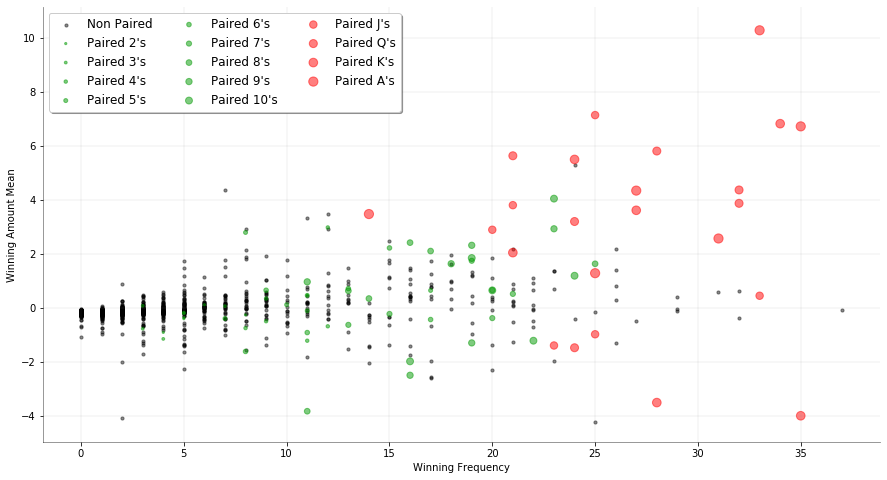

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
setAxConfig(ax, '', 'Winning Frequency', 'Winning Amount Mean')

ax.scatter(
    card_wins[filt].times_won, card_wins[filt].avg_won,
    s = 10, c = 'black', label = 'Non Paired', alpha=0.45
)

for key, group in list(grouped_cards):
    ax.scatter(
        group.times_won, group.avg_won,
        s = pow(key + 4, 2) // 3, alpha = 0.5,
        c = [(key >= 9, 0.6 * (key < 9), 0)] * len(group),
        label='Paired ' + card_vals[key] + '\'s'
    )
    
ax.legend(loc='upper left', shadow=True, fontsize=12, ncol=3);

It's kind of interesting that winning more often by a hand does not substentially bring more profit. It shows that playing with a high pair pays off as the mean values really show up high. Next we'll try to show which exact values work best when paired.

In [7]:
card_values = card_wins.apply(
    lambda row: pd.Series([
        row.card1[:-1], row.card2[:-1],
        row.avg_won, row.times_won
    ], index = ['val1', 'val2',  'avg_won', 'times_won']), 
    axis = 1, result_type = 'expand'
).groupby(
    ['val1', 'val2']
).apply(
    lambda df: pd.DataFrame(
        data = {
            'avg_won': [df.avg_won.mean()],
            'times_won': [df.times_won.sum()]
        }
    )
).ungroup()

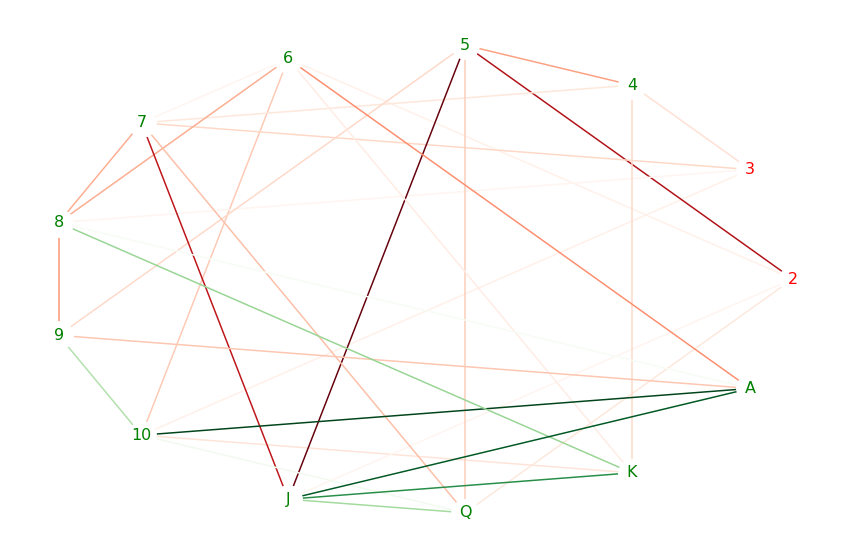

In [8]:
filt = card_values.val1 != card_values.val2

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
G = nx.Graph()
G.add_nodes_from(range(13))
layout = nx.circular_layout(G)

data = [([], []), ([], [])]
for i, row in card_values[filt].iterrows():
    i1 = card_val_idx[row.val1]
    i2 = card_val_idx[row.val2]
    G.add_nodes_from([i1, i2])
    if abs(row.avg_won) > 0.15: # graph density control
        G.add_edge(i1, i2)
        data[row.avg_won > 0][0].append((i1, i2))
        data[row.avg_won > 0][1].append(abs(row.avg_won))

for (edges, colors), cm in zip(data, [plt.cm.Reds, plt.cm.Greens]):
    nx.draw(
        G, layout, ax = ax, 
        node_size=750, node_color='white',
        edgelist=edges, edge_color=colors,
        width=1.5, edge_cmap=cm
    )
    
pairs = card_values[filt == False]
node_coloring = [dict(), dict()]
for val, won in zip(pairs.val1, pairs.avg_won):
    idx = card_val_idx[val]
    if won > 0: node_coloring[1][idx] = val
    if won < 0: node_coloring[0][idx] = val

for nodes, color in zip(node_coloring, ['red', 'green']):
    nx.draw_networkx_labels(
        G, layout, nodes, ax = ax,
        font_size = 16, font_color = color
    );

So here we colored connections which connect pairs that had positive winning average with green and those negative with red. The darker color shades represent more extremal values (A10 had an extremely high winning average). The node coloring represent the coloring of self-loops, which are not drawn. <br /><br />

So with this in mind we see that having a pair usually payed off, while playing with Jack is risky though sometimes profitable. That may be because playing Jacks can really go either way and holding to it for too long can make you lose money. It is interesting that high pairs like AK, KQ or AQ are not that interesting. Though we saw that those combinations have an incredibly large variance which seems to even out in the end. <br /><br />

Now focusing further on pairs there is a really logical result here, which shows that playing with basically any pair but 2's or 3's is profitable.

## Bluffs
We'll look at the bluff success of our player. We will need the data from the following two tables.

In [9]:
display(actions.sample(5))
display(blinds.sample(5))
display(board.sample(5))
display(received_cards.sample(5))

,action_id,amount,round_id,turn_id,action_order,user_id
248110,0.0,0.0,34388.0,0.0,3.0,927
255917,0.0,0.0,16379.0,0.0,3.0,990
152710,0.0,0.0,4171.0,0.0,6.0,244
191598,3.0,0.0,7370.0,2.0,11.0,468
327656,0.0,0.0,34351.0,0.0,5.0,1694


,user_id,blind_type_id,round_id,value
15032,5,0,37092.0,1.00
38046,204,1,5491.0,0.25
1749,5,0,1454.0,0.25
71983,1173,0,33222.0,0.50
13136,5,0,31839.0,0.25


,board,round_id,turn
36330,4♦ 2♦ 9♣ A♥ Q♠,39193,3
7094,9♥ 10♥ A♠ 7♥,7176,2
21232,K♥ 3♠ 9♣ Q♥,22425,2
38507,A♦ J♣ Q♠,41660,1
19761,J♣ J♥ 4♥ 7♠ 7♥,20772,3


,round_id,user_id,card1,card2
33516,33517.0,5,A♥,K♠
23892,23893.0,5,3♥,3♦
27363,27364.0,5,10♥,8♣
8673,8674.0,5,2♠,2♦
3452,3453.0,5,3♥,7♠


The plan is to focus on the actions where our player raised or bet a lot. At those events we are going to check if he was bluffing and what did it result in. But first we have to figure out what is a large amount. That is relative from round's blinds, and we will say that 10 * big blind constitutes as a large bet.

In [30]:
action_blinds = blinds[
    blinds.blind_type_id == 1
].drop(
    columns = ['user_id']
).merge(
    actions[actions.user_id == main_user_id], 
    'outer', 'round_id'
).dropna()

In [31]:
main_player_cards = received_cards.assign(
    hand = received_cards.card1 + ' ' + received_cards.card2
).drop(
    columns = ['card1', 'card2', 'user_id']
).merge(
    board, 'outer', 'round_id'
).dropna()

In [49]:
bluff_data = action_blinds[
    (action_blinds.amount > 5 * action_blinds.value) &
    ((action_blinds.action_id == ActionId.RAISE) | 
     (action_blinds.action_id == ActionId.BET))
].merge(
    main_player_cards, 'outer', 
    left_on = ['round_id', 'turn_id'],
    right_on = ['round_id', 'turn']
).drop(
    columns = [
        'user_id', 'action_order',
        'blind_type_id', 'action_id', 
        'turn_id', 'round_id'
    ]
).dropna()

strengths = bluff_data.assign(
    handstrength = bluff_data.apply(
        lambda row: pd.Series(
            [getHand(row.hand + ' ' + row.board)]
        ),
        axis = 1, result_type = 'expand'
    )
).assign(
    boardstrength = bluff_data.apply(
        lambda row: pd.Series(
            [getHand(row.board)]
        ),
        axis = 1, result_type = 'expand'
    )
).sort_values(
    by = ['handstrength']
)

strengths.head(10)

# get missing straight possitions so 
# you can classify close to straights

,value,amount,hand,board,turn,handstrength,boardstrength
1169,0.50,7.50,A♠ K♠,10♠ 8♦ Q♦,1.0,0,0
1748,0.50,3.00,10♣ J♠,K♠ 9♠ 5♥,1.0,0,0
533,0.25,1.90,A♠ Q♠,J♣ 7♣ 10♥,1.0,0,0
527,0.50,5.00,A♦ K♥,6♠ 8♣ Q♣,1.0,0,0
514,0.25,1.50,10♥ 9♣,7♣ Q♦ 6♥ J♣,2.0,0,0
512,0.50,2.85,10♠ Q♠,4♣ 8♣ 9♠,1.0,0,0
509,0.50,2.85,8♥ 9♥,7♠ A♦ 5♠,1.0,0,0
507,0.50,3.50,6♠ 8♠,10♥ 4♠ 2♦,1.0,0,0
1062,0.50,3.32,10♠ K♠,9♦ 2♣ 5♥,2.0,0,0
1790,0.25,1.75,J♣ K♥,10♥ 7♥ A♠,1.0,0,0


Now that we've got the info we can compare the winnings with bluffs and others.

## General Player Correlations
We'll gather some basic information about the players and show some correlations (or lack of). These will serve us as a rough insight into players' general behaviour. In this section we will treat bets as raises as they actually are raises in some form.

### Folds and Raises vs. Winnings
We will check if the fold average of a player has any effect on his winnings. <br />
This is a rough estimate of player's low agression level.

In [13]:
def actionSummary(df):
    count = Counter(df.action_id)
    return {
        action.name: [count[int(action)]]
        for action in ActionId
    }
        
action_summary = actions.groupby('user_id').apply(
    lambda df: pd.DataFrame(
        data = {
            **actionSummary(df),
            'all_actions': [len(df.action_id)]
        }
    )
).ungroup()
action_summary = action_summary[
    action_summary.user_id != main_user_id
]

In [14]:
winnings = cardshow.groupby('user_id').apply(
    lambda df: pd.DataFrame(
        data = {
            'total_won': [df.amount.sum()],
            'mean_won': [df.amount.mean()]
        }
    )
).ungroup()
winnings = winnings[winnings.user_id != main_user_id]

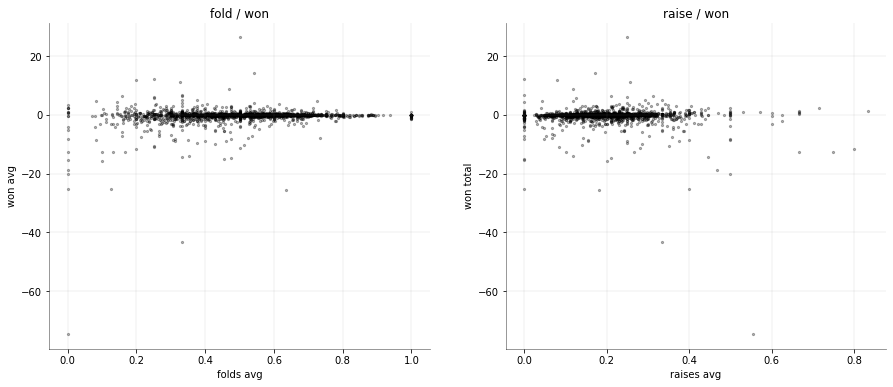

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
setAxConfig(ax1, 'fold / won', 'folds avg', 'won avg')
setAxConfig(ax2, 'raise / won', 'raises avg', 'won total')

ax1.scatter(
    action_summary.FOLD / action_summary.all_actions, 
    winnings.mean_won, s=5, c='black', alpha=0.3
)
ax2.scatter(
    (action_summary.RAISE + action_summary.BET) / action_summary.all_actions,
    winnings.mean_won, s=5, c='black', alpha=0.3
);

We see here that folding more often stabilizes relative winnings a bit, which makes sense as folding 99% of the time does keep the variance pretty still. Other than that there is no real correlation here.

### Raises vs. Raise Amount
Here we will check the correlation between players' raise frequency and raise amount.
We assume players who raise more frequently raise more as they are generally more agressive.

In [16]:
raise_stats = actions.groupby('user_id').apply(
    lambda df: pd.DataFrame(
        data = {
            'avg_raise': [
                df[
                    (df.action_id == ActionId.RAISE) |
                    (df.action_id == ActionId.BET)
                ].amount.mean()
            ]
        }
    )
).ungroup()
raise_stats.avg_raise = raise_stats.avg_raise.replace(pd.NaT, 0)
raise_stats = raise_stats[raise_stats.user_id != main_user_id]

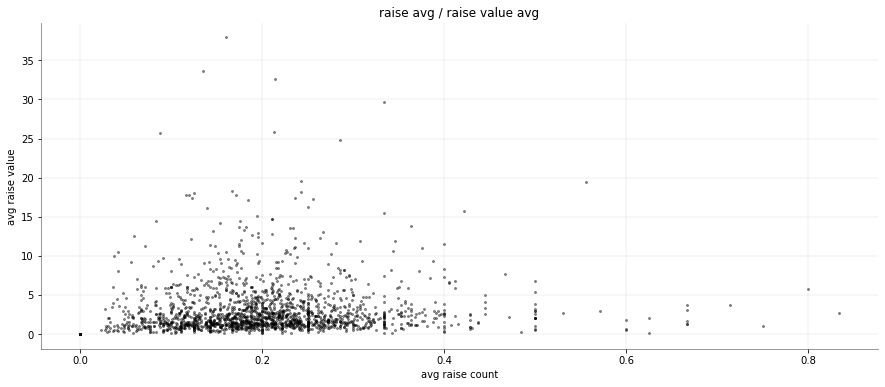

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
setAxConfig(ax, 'raise avg / raise value avg', 'avg raise count', 'avg raise value')
ax.scatter(
    (action_summary.RAISE + action_summary.BET) / action_summary.all_actions,
    raise_stats.avg_raise, s=4, c='black', alpha=0.4
);

Our speculation proved to be correct as there really is a slight positive correlation.